# Friedmann equations with lyra-geometry

This notebook reproduces the [SageMath Friedmann equations example](https://nbviewer.jupyter.org/github/sagemanifolds/SageManifolds/blob/master/Notebooks/SM_Friedmann_equations.ipynb) using the Python-only lyra-geometry API.


## Conventions and limitations

- Signature: $(-,+,+,+)$, with $c=1$.
- We use the comoving perfect-fluid 4-velocity $u^a = (1,0,0,0)$.
- lyra-geometry uses the Lyra connection strategy with $\phi=1$, zero torsion, and zero non-metricity, which reduces to the Levi-Civita connection.
- Symbolic simplifications rely on SymPy; some steps need explicit `simplify()`/`factor()` calls compared to SageMath's automatic formatting.


In [1]:
import sympy as sp
import lyra_geometry as lg

sp.init_printing()


In [2]:
# Coordinates and parameters
t, r, theta, phi = sp.symbols("t r theta phi", real=True)
G, Lambda, k = sp.symbols("G Lambda k", real=True)

a = sp.Function("a")(t)
rho = sp.Function("rho")(t)
p = sp.Function("p")(t)


In [3]:
# FLRW metric in (t, r, theta, phi)
metric = sp.diag(
    -1,
    a**2 / (1 - k * r**2),
    a**2 * r**2,
    a**2 * r**2 * sp.sin(theta) ** 2,
)

space = lg.TensorSpace(coords=(t, r, theta, phi), metric=metric)
space.metric.components


⎡-1      0          0             0        ⎤
⎢                                          ⎥
⎢       2                                  ⎥
⎢      a (t)                               ⎥
⎢0   ──────────     0             0        ⎥
⎢         2                                ⎥
⎢    - k⋅r  + 1                            ⎥
⎢                                          ⎥
⎢                 2  2                     ⎥
⎢0       0       r ⋅a (t)         0        ⎥
⎢                                          ⎥
⎢                           2  2       2   ⎥
⎣0       0          0      r ⋅a (t)⋅sin (θ)⎦

In [4]:
# Levi-Civita connection (Gamma^a_{bc})
Gamma = space.christoffel2
Gamma.components


⎡                                                                ⎡           d ↪
⎢⎡0        0               0                     0            ⎤  ⎢           ─ ↪
⎢⎢                                                            ⎥  ⎢           d ↪
⎢⎢        d                                                   ⎥  ⎢   0       ─ ↪
⎢⎢   a(t)⋅──(a(t))                                            ⎥  ⎢             ↪
⎢⎢        dt                                                  ⎥  ⎢             ↪
⎢⎢0  ─────────────         0                     0            ⎥  ⎢d            ↪
⎢⎢         2                                                  ⎥  ⎢──(a(t))     ↪
⎢⎢    - k⋅r  + 1                                              ⎥  ⎢dt           ↪
⎢⎢                                                            ⎥  ⎢────────  ── ↪
⎢⎢                   2      d                                 ⎥  ⎢  a(t)       ↪
⎢⎢0        0        r ⋅a(t)⋅──(a(t))             0            ⎥  ⎢          -  ↪
⎢⎢                          

In [5]:
# Ricci tensor and Ricci scalar
Ricci = space.ricci
R = space.ricci_scalar()

Ricci.components, R.components[()]


⎛⎡   2                                                                         ↪
⎜⎢  d                                                                          ↪
⎜⎢3⋅───(a(t))                                                                  ↪
⎜⎢    2                                                                        ↪
⎜⎢  dt                                                                         ↪
⎜⎢───────────                   0                                        0     ↪
⎜⎢   a(t)                                                                      ↪
⎜⎢                                                                             ↪
⎜⎢                         2                      2                            ↪
⎜⎢                        d             ⎛d       ⎞                             ↪
⎜⎢             2⋅k + a(t)⋅───(a(t)) + 2⋅⎜──(a(t))⎟                             ↪
⎜⎢                          2           ⎝dt      ⎠                             ↪
⎜⎢                        dt

## Perfect fluid energy-momentum tensor

$T_{ab} = (ho + p) u_a u_b + p g_{ab}$ with $u^a = (1,0,0,0)$.


In [6]:
u = space.from_array([1, 0, 0, 0], signature=(lg.U,), name="u")
u_down = u(lg.D)

a_idx, b_idx = space.index("a b")
g = space.metric

T_indexed = (rho + p) * (u_down[-a_idx] * u_down[-b_idx]) + p * g[-a_idx, -b_idx]
T = space.tensor(T_indexed, name="T")

# Check normalization: u^a u_a = -1
u_norm = (u[+a_idx] * u_down[-a_idx]).fmt()
T.components, u_norm.components[()]


⎛⎡ρ(t)      0             0                  0          ⎤    ⎞
⎜⎢                                                      ⎥    ⎟
⎜⎢       2                                              ⎥    ⎟
⎜⎢      a (t)⋅p(t)                                      ⎥    ⎟
⎜⎢ 0    ──────────        0                  0          ⎥    ⎟
⎜⎢           2                                          ⎥    ⎟
⎜⎢      - k⋅r  + 1                                      ⎥, -1⎟
⎜⎢                                                      ⎥    ⎟
⎜⎢                   2  2                               ⎥    ⎟
⎜⎢ 0        0       r ⋅a (t)⋅p(t)            0          ⎥    ⎟
⎜⎢                                                      ⎥    ⎟
⎜⎢                                  2  2            2   ⎥    ⎟
⎝⎣ 0        0             0        r ⋅a (t)⋅p(t)⋅sin (θ)⎦    ⎠

In [7]:
# Trace of T: T = g^{ab} T_{ab}
m_idx, n_idx = space.index("m n")
T_trace = (space.metric_inv_tensor[+m_idx, +n_idx] * T[-m_idx, -n_idx]).fmt()
T_trace.components[()]


## Einstein equations and Friedmann equations

Standard form: $R_{ab} - \frac{1}{2}g_{ab} R  + \Lambda g_{ab} = 8\pi G\,T_{ab}$.

Trace-reversed form: $R_{ab} - \Lambda g_{ab} = 8\pi G\,(T_{ab} - 	\frac{1}{2} T g_{ab})$.


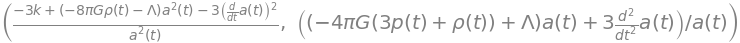

In [8]:
E1 = (
    Ricci[-a_idx, -b_idx]
    - sp.Rational(1, 2) * R * g[-a_idx, -b_idx]
    + Lambda * g[-a_idx, -b_idx]
    - (8 * sp.pi * G) * T[-a_idx, -b_idx]
)

E2 = (
    Ricci[-a_idx, -b_idx]
    - Lambda * g[-a_idx, -b_idx]
    - (8 * sp.pi * G) * (T[-a_idx, -b_idx] - sp.Rational(1, 2) * T_trace * g[-a_idx, -b_idx])
)

E1_00 = sp.simplify(E1.components[0, 0])
E2_00 = sp.simplify(E2.components[0, 0])

E1_00, E2_00


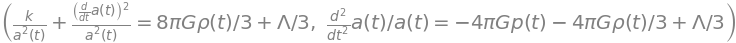

In [11]:
# Put the 00-components in the standard cosmology form
a_dot = sp.diff(a, t)
a_ddot = sp.diff(a, t, 2)

friedmann_1 = sp.Eq((a_dot**2 + k) / a**2, (8 * sp.pi * G * rho + Lambda) / 3)
friedmann_2 = sp.Eq(a_ddot / a, (-4 * sp.pi * G * (rho + 3 * p) + Lambda) / 3)

sp.expand(friedmann_1), sp.expand(friedmann_2)
